In [5]:
import numpy as np

from thinkstats2 import RandomSeed

import utils

import thinkplot
import matplotlib.pyplot as plt

In [6]:
class Simulation:
    
    def __init__(self, fit_land, agents):
        """Create the simualtion:
        
        fit_land: fit_land
        num_agents: int number of agents
        agent_maker: function that makes agents
        """
        self.fit_land = fit_land
        self.agents = np.asarray(agents)
        self.instruments = []
        
    def add_instrument(self, instrument):
        """Adds an instrument to the list.
        
        instrument: Instrument object
        """
        self.instruments.append(instrument)
        
    def plot(self, index, *args, **kwargs):
        """Plot the results from the indicated instrument.
        """
        self.instruments[index].plot(*args, **kwargs)
        
    def run(self, num_steps=500):
        """Run the given number of steps.
        
        num_steps: integer
        """
        # initialize any instruments before starting
        self.update_instruments()
        
        for _ in range(num_steps):
            self.step()
            
    def step(self):
        """Simulate a timestep and update the instruments.
        """
        n = len(self.agents)
        fits = self.get_fitnesses()
        
        # see who dies
        index_dead = self.choose_dead(fits)
        num_dead = len(index_dead)
        
        # replace the dead with copies of the living
        replacements = self.choose_replacements(num_dead, fits)
        self.agents[index_dead] = replacements
        
        # update any instrument
        self.update_instruments()
        
    def update_instruments(self):
        for instrument in self.instruments:
            instrument.update(self)
            
    def get_locs(self):
        """Returns a list of agent locations."""
        return [tuple(agent.loc) for agent in self.agents]
    
    def get_fitnesses(self):
        """Returns an array of agent fitnesses."""
        fits = [agent.fitness for agent in self.agents]
        return np.array(fits)
    
    def choose_dead(self, ps):
        """Choose which agents die in the next timestep.
        
        ps: probability of survival for each agent
        
        returns: indices of the chosen ones
        """
        n = len(self.agents)
        is_dead = np.random.random(n) < 0.1
        index_dead = np.nonzero(is_dead)[0]
        return index_dead
    
    def choose_replacements(self, n, weights):
        """Choose which agents reproduce in the next timestep.
        
        n: number of choices
        weights: array of weights
        
        returns: sequence of Agent objects
        """
        agents = np.random.choice(self.agents, size=n, replace=True)
        replacements = [agent.copy() for agent in agents]
        return replacements

In [7]:
class Instrument:
    """Computes a metric at each timestep."""
    
    def __init__(self):
        self.metrics = []
        
    def update(self, sim):
        """Compute the current metric.
        
        Appends to self.metrics.
        
        sim: Simulation object
        """
        # child classes should implement this method
        pass
    
    def plot(self, **options):
        thinkplot.plot(self.metrics, **options)

In [8]:
class MeanFitness(Instrument):
    """Computes mean firness at each timestep."""
    label = 'Mean fitness'
    
    def update(self, sim):
        mean = np.nanmean(sim.get_fitnesses())
        self.metrics.append(mean)

In [9]:
class Agent:
    
    keys = [(None, None),
           (None, 'C'),
           (None, 'D'),
           ('C', 'C'),
           ('C', 'D'),
           ('D', 'C'),
           ('D', 'D')]
    
    def __init__(self, values, fitness=np.nan):
        """Initialize the agent.
        
        values: sequence of 'C' and 'D'
        """
        self.values = values
        self.responses = dict(zip(self.keys, values))
        self.fitness = fitness
        
    def reset(self):
        """Reset variables before a sequence of games.
        """
        self.hist = [None, None]
        self.score = 0
        
    def past_responses(self, num=2):
        """select the given number of most recent responses.
        
        num: integer number of responses
        
        returns: sequence of 'C' and 'D'
        """
        return tuple(self.hist[-num:])
    
    def respond(self, other):
        """Choose a response based on the oponent's recent responses.
        
        other: Agent
        
        returns: 'C' or 'D'
        """
        key = other.past_responses()
        resp = self.responses[key]
        return resp
    
    def append(self, resp, pay):
        """Update based on the last response and payoff.
        
        resp: 'C' or 'D'
        pay: number
        """
        self.hist.append(resp)
        self.score += pay
        
    def copy(self, prob_mutate=0.05):
        """Make a copy of this agent.
        """
        if np.random.random() > prob_mutate:
            values = self.values
        else:
            values = self.mutate()
        return Agent(values, self.fitness)
    
    def mutate(self):
        """Makes a copy of this agent's values, with one mutation.
        
        returns: sequence of 'C' and 'D'
        """
        values = list(self.values)
        index = np.random.choice(len(values))
        values[index] = 'C' if values[index] == 'D' else 'D'
        return values

In [10]:
all_c = Agent('CCCCCCC')
all_c.responses

{(None, None): 'C',
 (None, 'C'): 'C',
 (None, 'D'): 'C',
 ('C', 'C'): 'C',
 ('C', 'D'): 'C',
 ('D', 'C'): 'C',
 ('D', 'D'): 'C'}

In [11]:
all_d = Agent('DDDDDDD')
all_d.responses

{(None, None): 'D',
 (None, 'C'): 'D',
 (None, 'D'): 'D',
 ('C', 'C'): 'D',
 ('C', 'D'): 'D',
 ('D', 'C'): 'D',
 ('D', 'D'): 'D'}

In [12]:
tft = Agent('CCDCDCD')
tft.responses

{(None, None): 'C',
 (None, 'C'): 'C',
 (None, 'D'): 'D',
 ('C', 'C'): 'C',
 ('C', 'D'): 'D',
 ('D', 'C'): 'C',
 ('D', 'D'): 'D'}

In [13]:
RandomSeed(16)
for i in range(10):
    print(all_d.copy().values)

DDDDDDD
DDDDDDD
DDDDDDD
['D', 'D', 'D', 'D', 'C', 'D', 'D']
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD


In [14]:
np.sum([all_d.copy().values != all_d.values for i in range(1000)])

52

# The Tournament

In [15]:
class Tournament:
    
    payoffs = {('C', 'C'): (3, 3),
              ('C', 'D'): (0, 5),
              ('D', 'C'): (5, 0),
              ('D', 'D'): (1, 1)}
    
    num_rounds = 6
    
    def play(self, agent1, agent2):
        """Play a sequence of iterated PD rounds.
        
        agent1: Agent
        agent2: Agent
        
        returns: tuple of agent1's score, agent2's score
        """
        agent1.reset()
        agent2.reset()
        
        for i in range(self.num_rounds):
            resp1 = agent1.respond(agent2)
            resp2 = agent2.respond(agent1)
            
            pay1, pay2 = self.payoffs[resp1, resp2]
            
            agent1.append(resp1, pay1)
            agent2.append(resp2, pay2)
        
        return agent1.score, agent2.score
    
    def melee(self, agents, randomize=True):
        """Play each agent against two others.
        
        Assigns the average score from the two games to agent.fitness
        
        agents: sequence of Agents
        randomize: boolean, whether to shuffle the agents
        """
        if randomize:
            agents = np.random.permutation(agents)
            
        n = len(agents)
        i_row = np.arange(n)
        j_row = (i_row + 1) % n
        
        totals = np.zeros(n)
        
        for i, j in zip(i_row, j_row):
            agent1, agent2 = agents[i], agents[j]
            score1, score2 = self.play(agent1, agent2)
            totals[i] += score1
            totals[j] += score2
            
        for i in i_row:
            agents[i].fitness = totals[i] / self.num_rounds / 2

In [16]:
tour = Tournament()
tour.play(all_d, all_c)

(30, 0)

In [17]:
tour.play(all_d, tft)

(10, 5)

In [18]:
tour.play(tft, all_c)

(18, 18)

In [19]:
agents = [all_c, all_d, tft]
agents

In [20]:
tour.melee(agents)

In [21]:
for agent in agents:
    print(agent.values, agent.fitness)

CCCCCCC 1.5
DDDDDDD 3.3333333333333335
CCDCDCD 1.9166666666666667


In [22]:
x = [1, 2, 3, 4]
n=len(x)
x[-(n-1):]

[2, 3, 4]

## Probability of Survival

In [23]:
def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, nu=1):
    """Computes the generalize logistic function.
    
    A: controls the lower bound
    B: controls the steepness of the transition
    C: not all that useful, AFAIK
    M: controls the location of the transition
    K: controls the upper bound
    !: shift the transition left or right
    nu: affects the symmetry of the transition
    
    returns: float or array
    """
    exponent = -B * (x - M)
    denom = C + Q * np.exp(exponent)
    return A + (K-A) / denom ** (1/nu)

In [24]:
def prob_survive(scores):
    """Probability of survival, based on fitness.
    
    scores: sequence of scores, 0-60
    
    returns: probability
    """
    return logistic(scores, A=0.7, B=1.5, M=2.5, K=0.9)

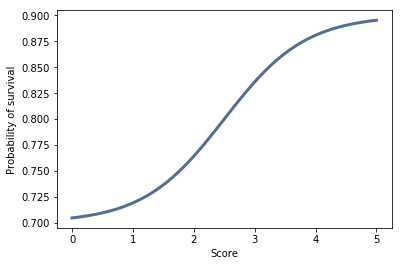

In [25]:
scores = np.linspace(0, 5)
probs = prob_survive(scores)
thinkplot.plot(scores, probs)
thinkplot.config(xlabel='Score', ylabel='Probability of survival')

# The simulator

In [26]:
class PDSimulation(Simulation):
    
    def __init__(self, tournament, agents):
        """Create the simulation:
        
        tournament: Tournament object
        agents: sequence of agents
        """
        self.tournament = tournament
        self.agents = np.asarray(agents)
        self.instruments = []
        
    def step(self):
        """Simulate a time step and update the instruments.
        """
        self.tournament.melee(self.agents)
        Simulation.step(self)
        
    def choose_dead(self, fits):
        """Choose which agents die in the next timestep.
        
        fits: fitness of each agent
        
        returns: indices of the chosen ones
        """
        ps = prob_survive(fits)
        n = len(self.agents)
        is_dead = np.random.random(n) < ps
        index_dead = np.nonzero(is_dead)[0]
        return index_dead

In [27]:
def make_random_agents(n):
    """Make agents with random genotype.
    
    n: number of agents
    
    returns: sequence of agents
    """
    agents = [Agent(np.random.choice(['C', 'D'], size=7))
             for _ in range(n)]
    return agents

In [28]:
def make_identical_agents(n, values):
    """Make agents with the given genotype.
    
    n: number of agents
    values: sequence of 'C' and 'D'
    
    returns: sequence of agents
    """
    agents = [Agent(values) for _ in range(n)]
    return agents

In [29]:
class Niceness(Instrument):
    """Fraction of cooperation in all genotypes."""
    label = 'Niceness'
    
    def update(self, sim):
        responses = np.array([agent.values for agent in sim.agents])
        metric = np.mean(responses == 'C')
        self.metrics.append(metric)

In [30]:
class Opening(Instrument):
    """Fraction of agents that cooperate on the first round."""
    label = 'Opening'
    
    def update(self, sim):
        responses = np.array([agent.values[0] for agent in sim.agents])
        metric = np.mean(responses == 'C')
        self.metrics.append(metric)

In [31]:
class Retaliating(Instrument):
    """Tendency to defect after the opponent defects."""
    label = 'Retaliating'
    
    def update(self, sim):
        after_d = np.array([agent.values[2::2] for agent in sim.agents])
        after_c = np.array([agent.values[1::2] for agent in sim.agents])
        metric = np.mean(after_d == 'D') - np.mean(after_c == 'D')
        self.metrics.append(metric)

In [32]:
class Forgiving(Instrument):
    """Tendency to cooperate if opponent cooperates after defecting."""
    label = 'Forgiving'
    
    def update(self, sim):
        after_dc = np.array([agent.values[5] for agent in sim.agents])
        after_cd = np.array([agent.values[4] for agent in sim.agents])
        metric = np.mean(after_dc == 'C') - np.mean(after_cd == 'C')
        self.metrics.append(metric)

In [33]:
class Forgiving2(Instrument):
    """Ability to cooperate after the first two rounds."""
    label = 'Forgiving2'
    
    def update(self, sim):
        after_two = np.array([agent.values[3:] for agent in sim.agents])
        metric = np.mean(np.any(after_two=='C', axis=1))
        self.metrics.append(metric)

## Results

In [34]:
RandomSeed(17)
tour = Tournament()

agents = make_identical_agents(100, list('DDDDDDD'))
sim = PDSimulation(tour, agents)

sim.add_instrument(MeanFitness())
sim.add_instrument(Niceness())
sim.add_instrument(Opening())
sim.add_instrument(Retaliating())
sim.add_instrument(Forgiving())

In [35]:
RandomSeed(17)
sim.run(5000)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


In [36]:
def plot_result(index, **options):
    """Plot the results of the indicated instrument.
    
    index: integer
    """
    sim.plot(index, **options)
    instrument = sim.instruments[index]
    print(np.mean(instrument.metrics[1000:]))
    thinkplot.Config(xlabel='Time steps',
                    ylabel=instrument.label)

In [37]:
colors = ['#f7fcf0','#e0f3db','#ccebc5','#a8ddb5','#7bccc4','#4eb3d3','#2b8cbe','#0868ac','#084081']

2.5006129717570604


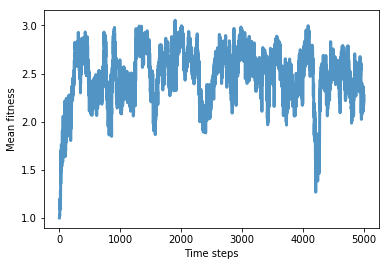

In [38]:
plot_result(0, color=colors[7])

0.6453083157781982


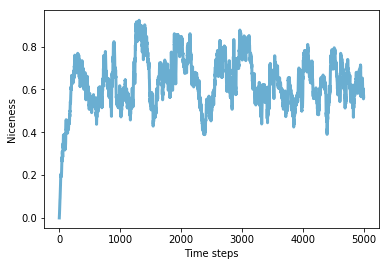

In [39]:
plot_result(1, color=colors[6])

0.67127968007998


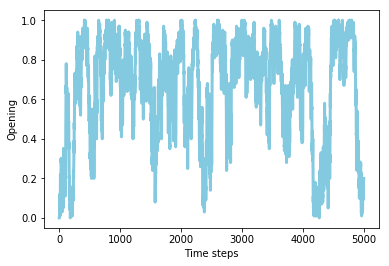

In [40]:
plot_result(2, color=colors[5])

0.6453083157781982
0.67127968007998


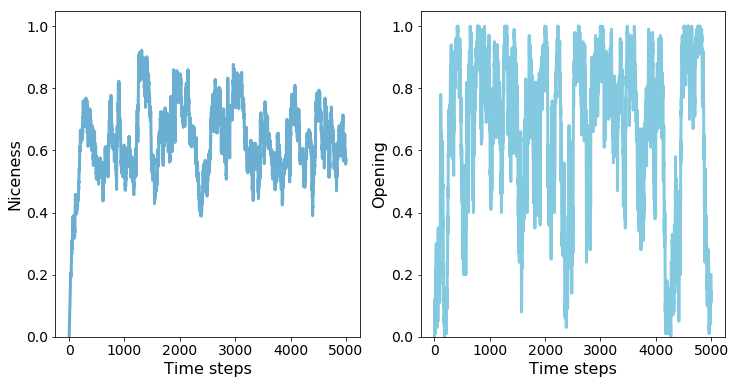

In [41]:
thinkplot.preplot(cols=2)
plot_result(1, color=colors[6])
thinkplot.config(ylim=[0, 1.05])
thinkplot.bigger_text()

thinkplot.subplot(2)
plot_result(2, color=colors[5])
thinkplot.config(ylim=[0, 1.05])
thinkplot.bigger_text()

0.07278680329917521


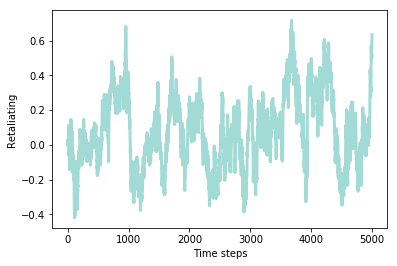

In [42]:
plot_result(3, color=colors[4])

-0.009162709322669325


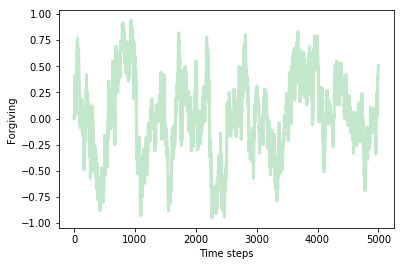

In [43]:
plot_result(4, color=colors[3])

In [44]:
for agent in sim.agents:
    print(agent.values)

['D', 'C', 'D', 'C', 'C', 'C', 'C']
['D', 'C', 'D', 'C', 'D', 'C', 'D']
['C', 'C', 'D', 'C', 'C', 'C', 'D']
['D', 'C', 'D', 'C', 'D', 'C', 'D']
['D', 'C', 'D', 'C', 'D', 'C', 'D']
['D', 'D', 'D', 'C', 'D', 'C', 'D']
['D', 'C', 'D', 'C', 'C', 'C', 'C']
['D', 'C', 'D', 'C', 'C', 'C', 'D']
['D', 'D', 'D', 'C', 'D', 'C', 'D']
['D', 'C', 'D', 'C', 'D', 'C', 'C']
['D', 'C', 'D', 'D', 'C', 'C', 'C']
['C', 'C', 'D', 'C', 'C', 'C', 'D']
['D', 'C', 'D', 'C', 'C', 'C', 'D']
['C', 'C', 'D', 'C', 'C', 'C', 'D']
['D', 'C', 'D', 'C', 'D', 'C', 'C']
['D', 'C', 'D', 'C', 'C', 'C', 'D']
['C', 'C', 'D', 'C', 'C', 'C', 'D']
['C', 'C', 'D', 'C', 'C', 'C', 'D']
['D', 'C', 'D', 'C', 'D', 'C', 'C']
['D', 'C', 'D', 'C', 'D', 'C', 'C']
['D', 'C', 'C', 'C', 'D', 'C', 'D']
['D', 'C', 'C', 'C', 'D', 'C', 'D']
['D', 'C', 'D', 'C', 'D', 'C', 'D']
['D', 'C', 'D', 'C', 'C', 'C', 'D']
['D', 'C', 'D', 'C', 'C', 'C', 'D']
['D', 'C', 'D', 'C', 'D', 'C', 'D']
['C', 'C', 'D', 'C', 'D', 'C', 'C']
['D', 'C', 'D', 'C', 'D', 'C

In [45]:
from pandas import Series

responses = [''.join(agent.values) for agent in sim.agents]
Series(responses).value_counts()

DCDCDCD    20
DCDCCCD    20
DCDCCCC    10
CCDCCCD    10
DCCCDCD     9
CCDCDCC     7
DCDCDCC     7
DDDCDCD     6
DCDDCCC     3
DDCCCDC     2
CCDDCCD     2
DDCCCCD     1
DDDCDCC     1
CCCCDCD     1
DCCCDCC     1
dtype: int64

# Exercises

## 12.1.a

In [46]:
def plot_results(sim, index, **options):
    """Plot the results of the indicated instrument.
    
    index: integer
    """
    sim.plot(index, **options)
    instrument = sim.instruments[index]
    print(np.mean(instrument.metrics[1000:]))
    thinkplot.Config(xlabel='Time steps',
                    ylabel=instrument.label)

0.6453083157781982
0.67127968007998
0.07278680329917521
-0.009162709322669325


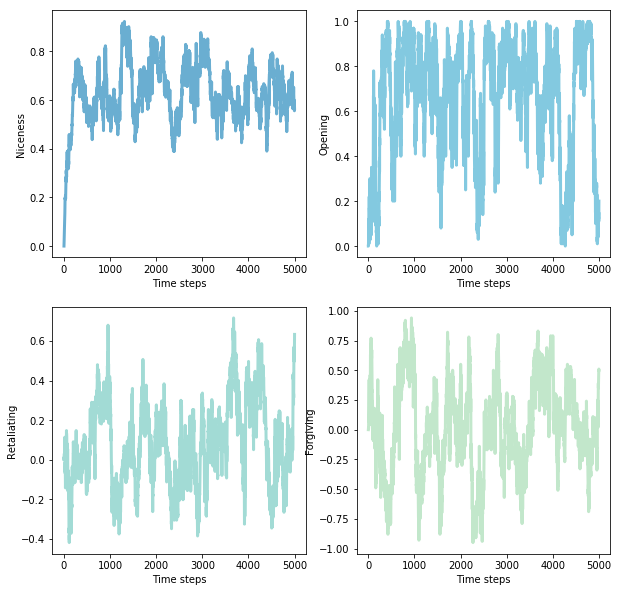

In [47]:
RandomSeed(17)
tourC = Tournament()

agentsC = make_identical_agents(100, list('CCCCCCC'))
simC = PDSimulation(tourC, agents)

simC.add_instrument(MeanFitness())
simC.add_instrument(Niceness())
simC.add_instrument(Opening())
simC.add_instrument(Retaliating())
simC.add_instrument(Forgiving())

simC.run(5000)

thinkplot.preplot(cols=2, rows=2)
plot_results(simC, 1, color=colors[6])

thinkplot.subplot(2)
plot_results(simC, 2, color=colors[5])

thinkplot.subplot(3)
plot_results(simC, 3, color=colors[4])

thinkplot.subplot(4)
plot_results(simC, 4, color=colors[3])

2.5006129717570604


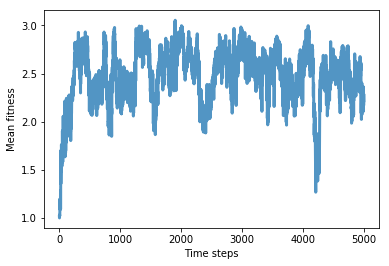

In [48]:
plot_results(simC, 0, color=colors[7])

0.6453083157781982
0.67127968007998
0.07278680329917521
-0.009162709322669325


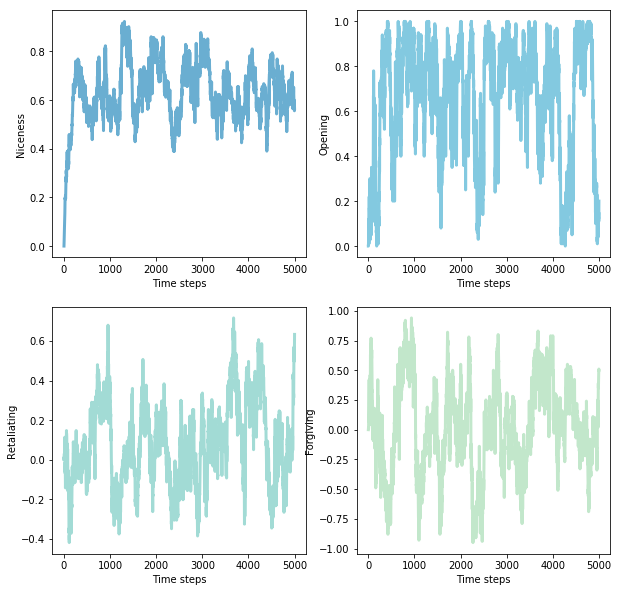

In [49]:
RandomSeed(17)
tourT = Tournament()

agentsT = make_identical_agents(100, list('CCDCDCD'))
simT = PDSimulation(tourT, agents)

simT.add_instrument(MeanFitness())
simT.add_instrument(Niceness())
simT.add_instrument(Opening())
simT.add_instrument(Retaliating())
simT.add_instrument(Forgiving())

simT.run(5000)

thinkplot.preplot(cols=2, rows=2)
plot_results(simT, 1, color=colors[6])

thinkplot.subplot(2)
plot_results(simT, 2, color=colors[5])

thinkplot.subplot(3)
plot_results(simT, 3, color=colors[4])

thinkplot.subplot(4)
plot_results(simT, 4, color=colors[3])

2.5006129717570604


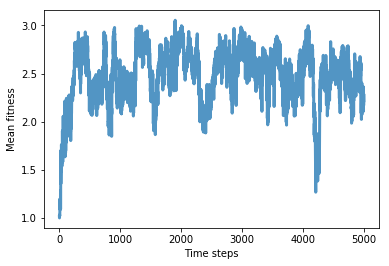

In [50]:
plot_results(simT, 0, color=colors[7])

0.6236230228157246
0.7321394651337165
0.08740314921269682
0.11472381904523872


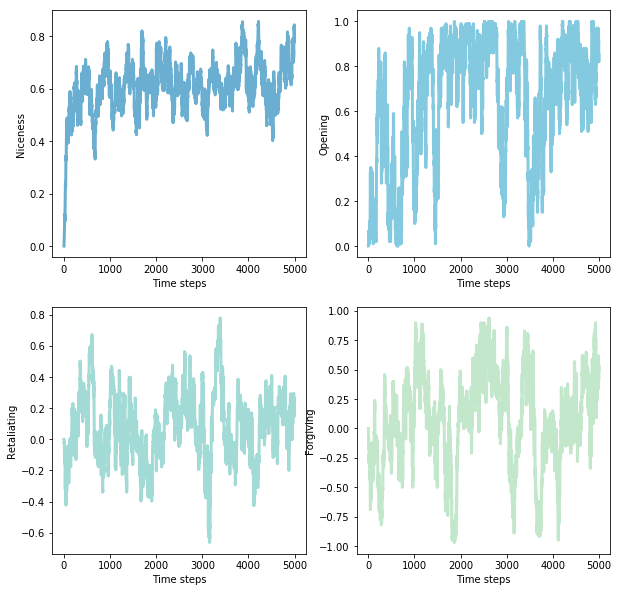

In [51]:
RandomSeed(17)
tourR = Tournament()

agentsR = make_random_agents(100)
simR = PDSimulation(tourR, agents)

simR.add_instrument(MeanFitness())
simR.add_instrument(Niceness())
simR.add_instrument(Opening())
simR.add_instrument(Retaliating())
simR.add_instrument(Forgiving())

simR.run(5000)

thinkplot.preplot(cols=2, rows=2)
plot_results(simR, 1, color=colors[6])

thinkplot.subplot(2)
plot_results(simR, 2, color=colors[5])

thinkplot.subplot(3)
plot_results(simR, 3, color=colors[4])

thinkplot.subplot(4)
plot_results(simR, 4, color=colors[3])

2.4575399900024992


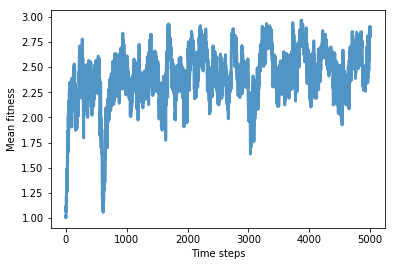

In [52]:
plot_results(simR, 0, color=colors[7])

## 12.1.b

In [53]:
class PDSimulationNoRandomize(PDSimulation):
    
    def step(self):
        """Simulate the time step and update the instruments.
        """
        self.tournament.melee(self.agents, randomize=False)
        Simulation.step(self)

0.6282218731031528
0.6297200699825044
0.033989835874364736
-0.014343914021494633


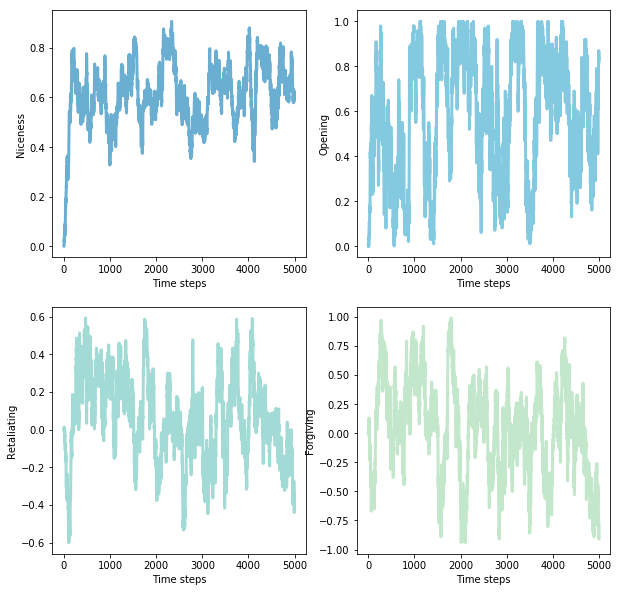

In [54]:
RandomSeed(17)
tourD = Tournament()

agentsD = make_identical_agents(100, list('DDDDDDD'))
simD = PDSimulationNoRandomize(tourD, agents)

simD.add_instrument(MeanFitness())
simD.add_instrument(Niceness())
simD.add_instrument(Opening())
simD.add_instrument(Retaliating())
simD.add_instrument(Forgiving())

simD.run(5000)

thinkplot.preplot(cols=2, rows=2)
plot_results(simD, 1, color=colors[6])

thinkplot.subplot(2)
plot_results(simD, 2, color=colors[5])

thinkplot.subplot(3)
plot_results(simD, 3, color=colors[4])

thinkplot.subplot(4)
plot_results(simD, 4, color=colors[3])

2.4424248104640505


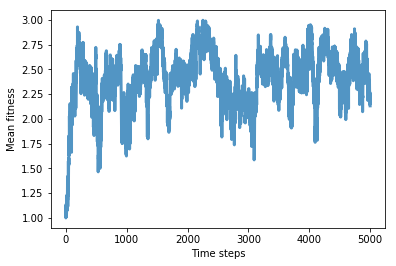

In [55]:
plot_results(simD, 0, color=colors[7])

2.4424248104640505


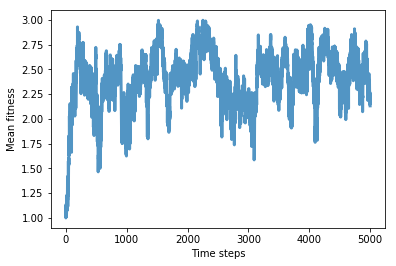

In [56]:
RandomSeed(17)
tourCC = Tournament()

agentsCC = make_identical_agents(100, list('CCCCCCC'))
simCC = PDSimulationNoRandomize(tourCC, agents)

simCC.add_instrument(MeanFitness())

simCC.run(5000)

plot_results(simCC, 0, color=colors[7])

2.4424248104640505


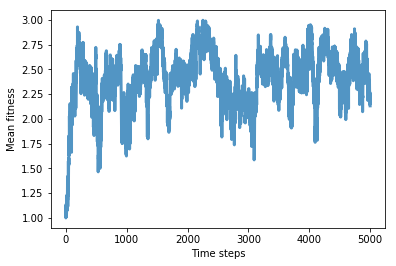

In [57]:
RandomSeed(17)
tourTT = Tournament()

agentsTT = make_identical_agents(100, list('CCDCDCD'))
simTT = PDSimulationNoRandomize(tourTT, agents)

simTT.add_instrument(MeanFitness())

simTT.run(5000)

plot_results(simTT, 0, color=colors[7])

2.336817254019828


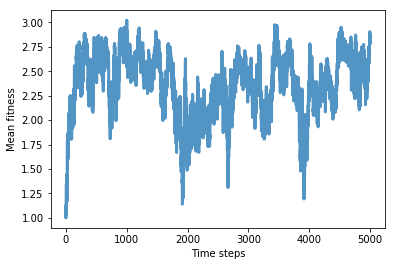

In [58]:
RandomSeed(17)
tourRR = Tournament()

agentsRR = make_random_agents(100)
simRR = PDSimulationNoRandomize(tourRR, agents)

simRR.add_instrument(MeanFitness())

simRR.run(5000)

plot_results(simRR, 0, color=colors[7])

## 12.1.c

In [59]:
class Tournament3Rounds(Tournament):
     
    def melee(self, agents, randomize=True):
        """Play each agent against three others.
        
        Assigns the average score from the two games to agent.fitness
        
        agents: sequence of Agents
        num_games: number of games played by each agent
        randomize: boolean, whether to shuffle the agents
        """
        num_games = 3
        
        if randomize:
            agents = np.random.permutation(agents)
            
        n = len(agents)
        i_row = np.arange(n)
                
        totals = np.zeros(n)
        
        for i in i_row:
            for j in range(1, num_games):
                agent1, agent2 = agents[i], agents[(i+j) % n]
                score1, score2 = self.play(agent1, agent2)
                totals[i] += score1
                totals[(i+j) % n] += score2
            
        for i in i_row:
            agents[i].fitness = totals[i] / self.num_rounds / num_games

3.3155736065983508


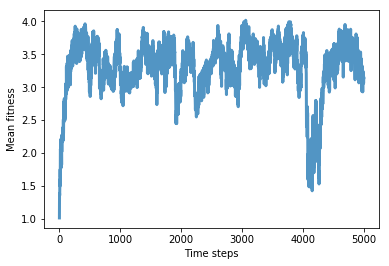

In [60]:
tourDDD = Tournament3Rounds()

agentsDDD = make_identical_agents(100, list('DDDDDDD'))
# agentsDDD = make_random_agents(100)
simDDD = PDSimulationNoRandomize(tourDDD, agents)

simDDD.add_instrument(MeanFitness())

simDDD.run(5000)

plot_results(simDDD, 0, color=colors[7])

## 12.1.d

In [61]:
def prob_survive(scores):
    """Probability of survival, based on fitness.
    
    scores: sequence of scores, 0-60
    
    returns: probability
    """
    return logistic(scores, A=0.7, B=1.5, M=2.5, K=0.9)

2.492974672998417


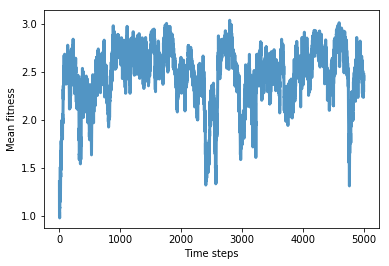

In [62]:
tourDDD = Tournament()

agentsDDD = make_identical_agents(100, list('DDDDDDD'))
# agentsDDD = make_random_agents(100)
simDDD = PDSimulationNoRandomize(tourDDD, agents)

simDDD.add_instrument(MeanFitness())

simDDD.run(5000)

plot_results(simDDD, 0, color=colors[7])

## 12.1.e

In [63]:
class NicenessLast4(Instrument):
    """Fraction of cooperation in all genotypes."""
    label = 'Niceness'
    
    def update(self, sim):
        responses = np.array([agent.values[-4:] for agent in sim.agents])
        metric = np.mean(responses == 'C')
        self.metrics.append(metric)

In [64]:
class TournamentMoreRounds(Tournament):
    
    num_rounds = 8

2.418973694076481
0.6588890277430642


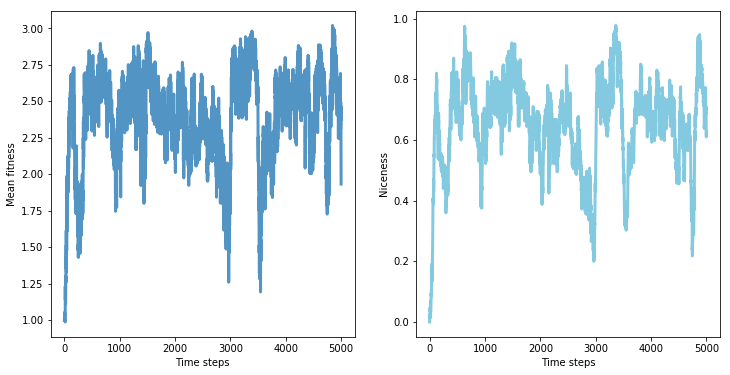

In [65]:
tourDDD = TournamentMoreRounds()

agentsDDD = make_identical_agents(100, list('DDDDDDD'))
# agentsDDD = make_random_agents(100)
simDDD = PDSimulationNoRandomize(tourDDD, agents)

simDDD.add_instrument(MeanFitness())
simDDD.add_instrument(NicenessLast4())


simDDD.run(5000)

thinkplot.preplot(cols=2)
plot_results(simDDD, 0, color=colors[7])

thinkplot.subplot(2)
plot_results(simDDD, 1, color=colors[5])

2.4153990668999414
0.6186828292926769


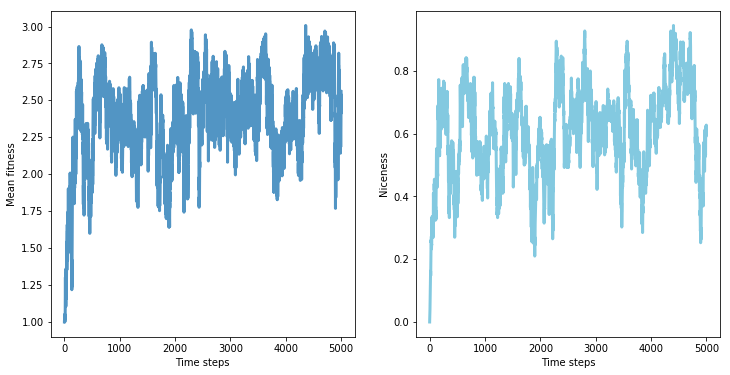

In [66]:
tourDDD = Tournament()

agentsDDD = make_identical_agents(100, list('DDDDDDD'))
# agentsDDD = make_random_agents(100)
simDDD = PDSimulation(tourDDD, agents)

simDDD.add_instrument(MeanFitness())
simDDD.add_instrument(NicenessLast4())


simDDD.run(5000)

thinkplot.preplot(cols=2)
plot_results(simDDD, 0, color=colors[7])

thinkplot.subplot(2)
plot_results(simDDD, 1, color=colors[5])

## 12.1.f

In [67]:
class PDSimulationWithDiffRep(PDSimulation):
    
    def choose_replacements(self, n, weights):
        """Choose which agents reproduce in the next timestep.
        
        n: number of choices
        weights: array of weights
        
        returns: sequence of Agent objects
        """
        ps = prob_survive(weights)
        num_d = len(self.agents)
        fittest = np.random.random(num_d) >= ps
        index_fittest = np.nonzero(fittest)[0]
                
        chosen_index = np.random.choice(index_fittest, size=n, replace=True)
        chosen = self.agents[chosen_index]
        
        replacements = [agent.copy() for agent in chosen]
        return replacements

2.1123098392068647
0.701327793051737


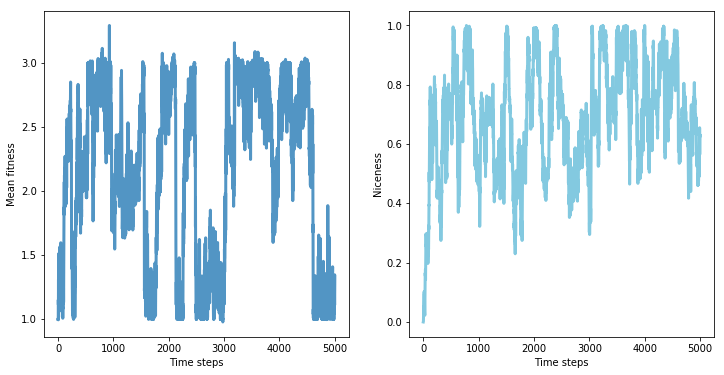

In [68]:
tourDDD = Tournament()

agentsDDD = make_identical_agents(100, list('DDDDDDD'))
# agentsDDD = make_random_agents(100)
simDDD = PDSimulationWithDiffRep(tourDDD, agents)

simDDD.add_instrument(MeanFitness())
simDDD.add_instrument(NicenessLast4())


simDDD.run(5000)

thinkplot.preplot(cols=2)
plot_results(simDDD, 0, color=colors[7])

thinkplot.subplot(2)
plot_results(simDDD, 1, color=colors[5])

## 12.2

In [69]:
def testScenarios(tourn, simIn, ins, agent_type='random', gen='CCCCCCC', num_agents=100, runs=5000):
    t = tourn()
    if agent_type == 'random':
        sim = simIn(t, make_random_agents(num_agents))
    else:
        sim = simIn(t, make_identical_agents(num_agents, gen))
    
    for i in ins:
        sim.add_instrument(i())
    
    sim.run(runs)
    
    ilen = len(ins)
    cols = ilen if ilen==1 else 2
    rows = 1 if ilen <= 2 else int(np.ceil(ilen / 3))
    
    
    thinkplot.preplot(cols=cols, rows=rows)
    for j in range(ilen):
        thinkplot.subplot(j+1)
        plot_results(sim, j)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


2.4312538532033656
0.6403252758239011


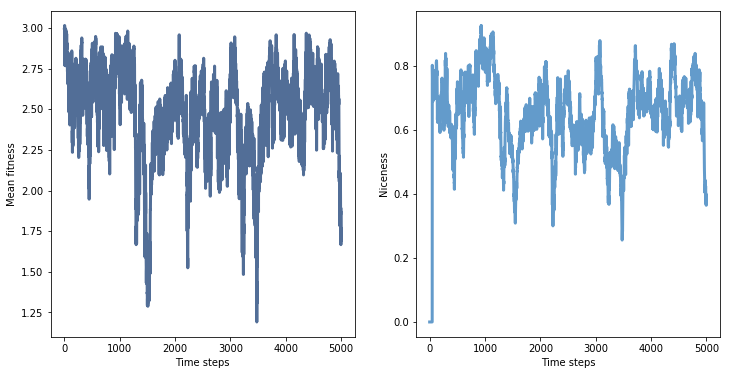

In [70]:
testScenarios(Tournament, PDSimulation, [MeanFitness, Niceness],
             agent_type='i')

In [71]:
class Agent2(Agent):
    '''
    def __init__(self, values, fitness=np.nan, **kwargs):
        """Initialize the agent.
        
        values: sequence of 'C' and 'D'
        """
        self.values = values
        self.responses = dict(zip(self.keys, values))
        self.fitness = fitness
        self.di = kwargs        
    '''
    def copy(self, prob_mutate=0.2):
        """Make a copy of this agent.
        """
        # prob_mutate = self.di['prob_mutate']
        if np.random.random() > prob_mutate:
            values = self.values
        else:
            values = self.mutate()
        return Agent2(values, self.fitness)

In [72]:
def make_random_agents2(n):
    """Make agents with random genotype.
    
    n: number of agents
    
    returns: sequence of agents
    """
    agents = [Agent2(np.random.choice(['C', 'D'], size=7))
             for _ in range(n)]
    return agents

def make_identical_agents2(n, values):
    """Make agents with the given genotype.
    
    n: number of agents
    values: sequence of 'C' and 'D'
    
    returns: sequence of agents
    """
    agents = [Agent2(values) for _ in range(n)]
    return agents

In [73]:
def testScenarios(tourn, simIn, ins, agent_type='random', gen='CCCCCCC', num_agents=100, runs=5000):
    t = tourn()
    if agent_type == 'random':
        sim = simIn(t, make_random_agents2(num_agents))
    else:
        sim = simIn(t, make_identical_agents2(num_agents, gen))
    
    for i in ins:
        sim.add_instrument(i())
    
    sim.run(runs)
    
    ilen = len(ins)
    cols = ilen if ilen==1 else 2
    rows = 1 if ilen <= 2 else int(np.ceil(ilen / 3))
    
    
    thinkplot.preplot(cols=cols, rows=rows)
    for j in range(ilen):
        thinkplot.subplot(j+1)
        plot_results(sim, j)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


2.33175872698492
0.5578076909344092


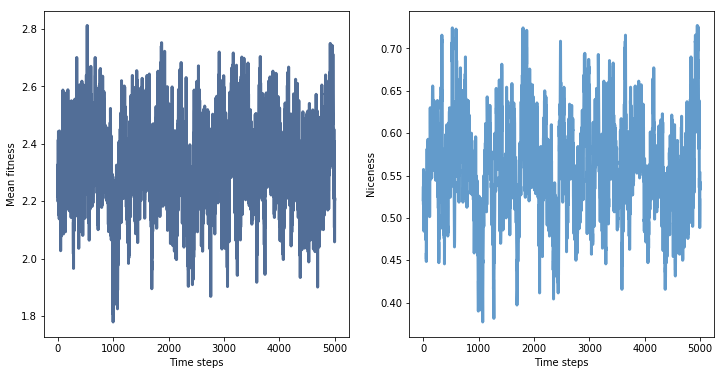

In [74]:
testScenarios(Tournament, PDSimulation, [MeanFitness, Niceness],
             agent_type='random')